# Descripción

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.
- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploración de datos

## Inicialización

In [1]:
#pip install scikit-learn --upgrade

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import math

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import f1_score, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

from IPython.display import display

## Carga de datos

Carga los datos y haz una revisión básica para comprobar que no hay problemas obvios.

In [3]:
df = pd.read_csv('/datasets/insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente con su estilo.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(15)

gender   age   income  family_members  insurance_benefits
3687       1  33.0  49600.0               0                   0
3977       1  32.0  41600.0               1                   0
3242       0  30.0  36600.0               1                   0
2935       1  25.0  33000.0               0                   0
2088       1  21.0  47900.0               2                   0
1368       0  27.0  22900.0               3                   0
1472       0  28.0  30500.0               1                   0
4061       1  36.0  45900.0               1                   0
96         0  23.0  43700.0               0                   0
1114       0  46.0  32800.0               0                   1
4220       1  36.0  28800.0               1                   0
4687       0  38.0  36400.0               1                   0
4286       0  27.0  27500.0               1                   0
3847       0  37.0  37300.0               2                   0
241        1  27.0  32400.0               1                   0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial

df['age'] = df['age'].astype(int)

In [8]:
# comprueba que la conversión se haya realizado con éxito

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [9]:
# ahora echa un vistazo a las estadísticas descriptivas de los datos.# ¿Se ve todo bien?

df.describe()

gender          age        income  family_members  \
count  5000.000000  5000.000000   5000.000000     5000.000000   
mean      0.499000    30.952800  39916.360000        1.194200   
std       0.500049     8.440807   9900.083569        1.091387   
min       0.000000    18.000000   5300.000000        0.000000   
25%       0.000000    24.000000  33300.000000        0.000000   
50%       0.000000    30.000000  40200.000000        1.000000   
75%       1.000000    37.000000  46600.000000        2.000000   
max       1.000000    65.000000  79000.000000        6.000000   

       insurance_benefits  
count         5000.000000  
mean             0.148000  
std              0.463183  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%              0.000000  
max              5.000000

In [10]:
df.duplicated().sum()

153

In [11]:
df.isnull().sum()

gender                0
age                   0
income                0
family_members        0
insurance_benefits    0
dtype: int64

Analizando la información del df con el describe, podemos apreciar que no hay faltantes en las columnas, los valores son adecuados y no presenta valores atípicos.

Por otro lado el df no contiene valores nulos, sin embargo si cuenta con valores duplicados, esto podría deberse a que puede suceder que haya casos iguales, sin necesidad de ser la misma persona, por lo tanto se decide no tratar los casos duplicados para no afectar la data.

## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

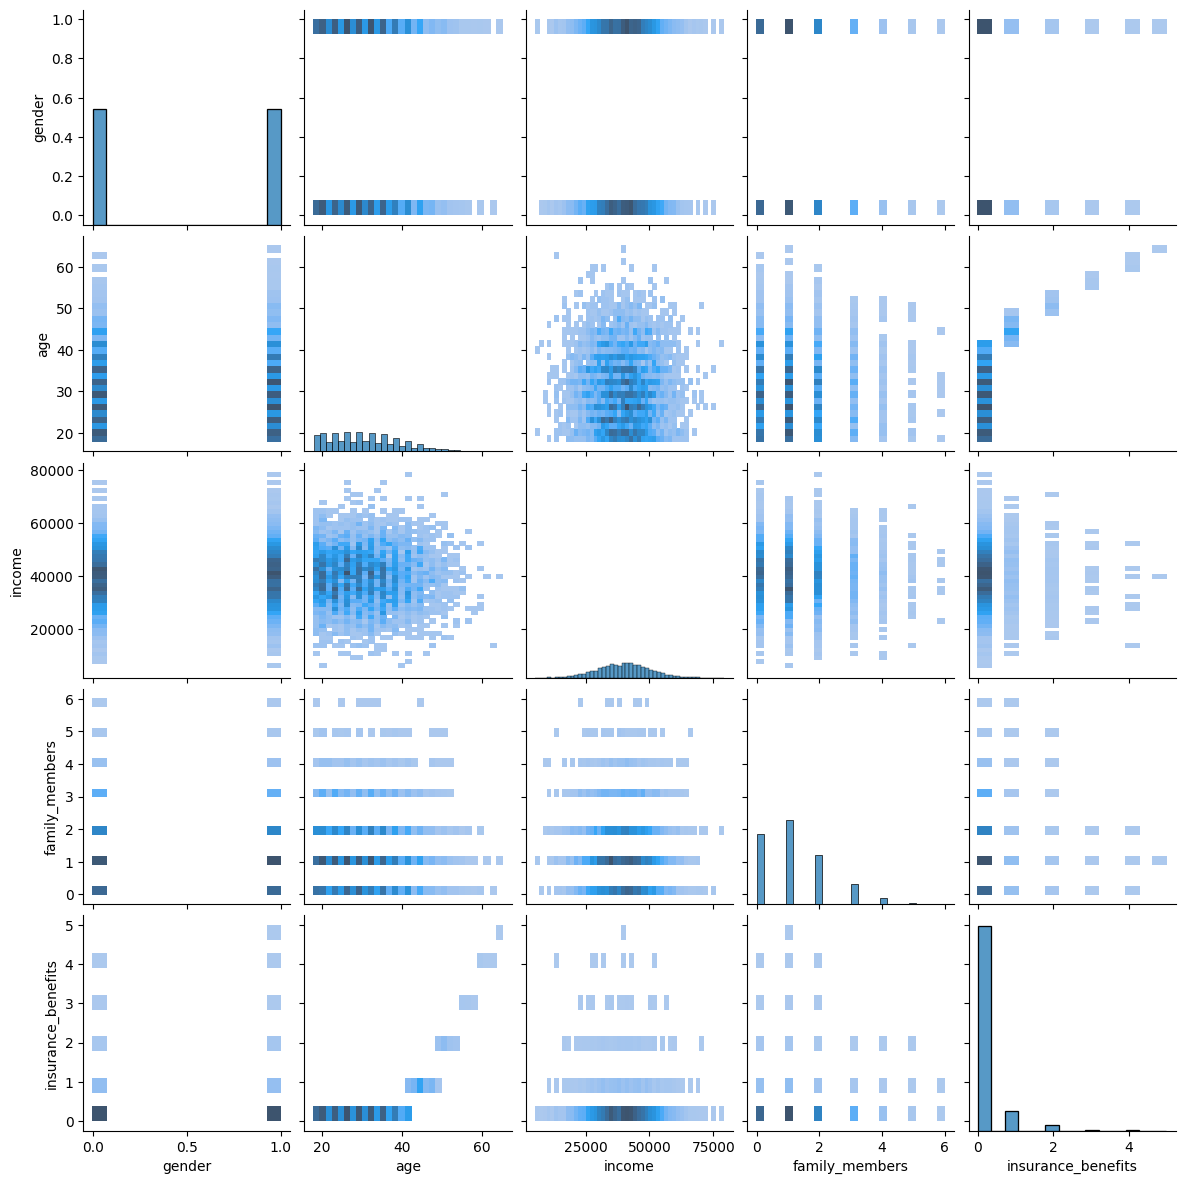

In [12]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.
Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes métricas de distancia.

Escribe una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas.
Puedes utilizar una implementación ya existente del algoritmo kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) o tu propia implementación.
Pruébalo para cuatro combinaciones de dos casos- Escalado
  - los datos no están escalados
  - los datos se escalan con el escalador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- Métricas de distancia
  - Euclidiana
  - Manhattan

Responde a estas preguntas:- ¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?- ¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

In [13]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [14]:
def get_knn(df, n, k, metric):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar    
    :param n: número de objetos para los que se buscan los vecinos más cercanos    
    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    """

    nbrs = NearestNeighbors(n_neighbors = n, metric = metric)
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Escalar datos.

In [15]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [16]:
df_scaled.sample(5)

gender       age    income  family_members  insurance_benefits
4600     0.0  0.553846  0.605063        0.333333                   0
3560     0.0  0.369231  0.517722        0.166667                   0
4783     0.0  0.523077  0.393671        0.333333                   0
3263     0.0  0.369231  0.355696        0.500000                   0
1603     0.0  0.523077  0.259494        0.000000                   0

Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

In [17]:
no_escale_euclidean = get_knn(df, n=10, k=6, metric='minkowski')
no_escale_euclidean.head(10)

gender  age   income  family_members  insurance_benefits  distance
10         1   25  36600.0               1                   0  0.000000
4039       1   25  36600.0               2                   0  1.000000
2037       1   26  36600.0               0                   0  1.414214
3247       1   26  36600.0               2                   0  1.414214
1508       0   26  36600.0               0                   0  1.732051
1949       0   24  36600.0               0                   0  1.732051

In [18]:
escale_euclidean = get_knn(df_scaled, n=10, k=6, metric='minkowski')
escale_euclidean.head(10)

gender       age    income  family_members  insurance_benefits  distance
10       1.0  0.384615  0.463291        0.166667                   0  0.000000
4377     1.0  0.384615  0.473418        0.166667                   0  0.010127
1389     1.0  0.369231  0.464557        0.166667                   0  0.015437
760      1.0  0.369231  0.462025        0.166667                   0  0.015437
2254     1.0  0.400000  0.455696        0.166667                   0  0.017157
3261     1.0  0.400000  0.473418        0.166667                   0  0.018418

In [19]:
no_escale_manhattan = get_knn(df, n=10, k=6, metric='manhattan')
no_escale_manhattan.head(10)

gender  age   income  family_members  insurance_benefits  distance
10         1   25  36600.0               1                   0       0.0
4039       1   25  36600.0               2                   0       1.0
2037       1   26  36600.0               0                   0       2.0
3247       1   26  36600.0               2                   0       2.0
1508       0   26  36600.0               0                   0       3.0
1949       0   24  36600.0               0                   0       3.0

In [20]:
escale_manhattan = get_knn(df_scaled, n=10, k=6, metric='manhattan')
escale_manhattan.head(10)

gender       age    income  family_members  insurance_benefits  distance
10       1.0  0.384615  0.463291        0.166667                   0  0.000000
4377     1.0  0.384615  0.473418        0.166667                   0  0.010127
1389     1.0  0.369231  0.464557        0.166667                   0  0.016650
760      1.0  0.369231  0.462025        0.166667                   0  0.016650
2254     1.0  0.400000  0.455696        0.166667                   0  0.022980
26       1.0  0.384615  0.437975        0.166667                   0  0.025316

Respuestas a las preguntas

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

Si afecta, en el hecho de que la magnitud de las distancias es más pequeña, y presenta valores similares también en el escalado.

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

Estos son ligeramente más altos que la métrica euclidiana, sin embargo, aún asi, son ligeramente similares.

# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.
Instrucciones:
- Construye un clasificador basado en KNN y mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementación ya existente del algoritmo de clasificación kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) o tu propia implementación.- Construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.
La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [21]:
# сalcula el objetivo

df['insurance_benefits_received'] = df['insurance_benefits'].apply(lambda x: 1 if x != 0 else 0)

features = df[['gender', 'age', 'income', 'family_members']].reset_index(drop=True)
target = df['insurance_benefits_received'].reset_index(drop=True)

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=123)
n_neighbors = 1

In [22]:
# comprueba el desequilibrio de clases con value_counts()

y = df['insurance_benefits_received']
class_counts = y.value_counts()

print("Conteo de clases:")
print(class_counts)

Conteo de clases:
0    4436
1     564
Name: insurance_benefits_received, dtype: int64


In [23]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# si tienes algún problema con la siguiente línea, reinicia el kernel y ejecuta el cuaderno de nuevo    

    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    #print('Matriz de confusión')
    #print(cm)
    return f1_score

In [24]:
# generar la salida de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [25]:
#Se evalúa el modelo dummy con diferentes valores

for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

La probabilidad: 0.00
F1: 0.00

La probabilidad: 0.11
F1: 0.12

La probabilidad: 0.50
F1: 0.20

La probabilidad: 1.00
F1: 0.20



In [26]:
#Se evalúa el modelo con la data sin escalar con valores de 1 - 10 neighbors

f1_scores = []

for n_neighbors in range (1,11):
    
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_classifier.fit(features_train, target_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = knn_classifier.predict(features_test)
    
    #Evaluamos los modelos y vamos agregando los resultados a la lista f1_scores
    f1_score = eval_classifier(target_test, y_pred)
    f1_scores.append((n_neighbors,f1_score))
    
    print(f"Vecinos más cercanos: {n_neighbors}, F1: {f1_score:.2f}")

F1: 0.67
Vecinos más cercanos: 1, F1: 0.67
F1: 0.40
Vecinos más cercanos: 2, F1: 0.40
F1: 0.41
Vecinos más cercanos: 3, F1: 0.41
F1: 0.20
Vecinos más cercanos: 4, F1: 0.20
F1: 0.23
Vecinos más cercanos: 5, F1: 0.23
F1: 0.14
Vecinos más cercanos: 6, F1: 0.14
F1: 0.14
Vecinos más cercanos: 7, F1: 0.14
F1: 0.06
Vecinos más cercanos: 8, F1: 0.06
F1: 0.08
Vecinos más cercanos: 9, F1: 0.08
F1: 0.03
Vecinos más cercanos: 10, F1: 0.03


In [27]:
#Se entrena el modelo ahora con la data escalada, se evalúa con valores de 1 a 10 neighbors

df_scaled['insurance_benefits_received'] = df_scaled['insurance_benefits'].apply(lambda x: 1 if x != 0 else 0)

# сalcula el objetivo
features = df_scaled[['gender', 'age', 'income', 'family_members']].reset_index(drop=True)
target = df_scaled['insurance_benefits_received'].reset_index(drop=True)

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=123)

In [28]:
f1_scores_scaled = []

for n_neighbors in range (1,11):

    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_classifier.fit(features_train, target_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = knn_classifier.predict(features_test)
    
    #Evaluamos los modelos y vamos agregando los resultados a la lista f1_scores
    f1_score = eval_classifier(target_test, y_pred)
    f1_scores_scaled.append((n_neighbors,f1_score))
    
    print(f"Vecinos más cercanos: {n_neighbors}, F1: {f1_score:.2f}")

F1: 0.95
Vecinos más cercanos: 1, F1: 0.95
F1: 0.92
Vecinos más cercanos: 2, F1: 0.92
F1: 0.93
Vecinos más cercanos: 3, F1: 0.93
F1: 0.90
Vecinos más cercanos: 4, F1: 0.90
F1: 0.92
Vecinos más cercanos: 5, F1: 0.92
F1: 0.93
Vecinos más cercanos: 6, F1: 0.93
F1: 0.94
Vecinos más cercanos: 7, F1: 0.94
F1: 0.93
Vecinos más cercanos: 8, F1: 0.93
F1: 0.93
Vecinos más cercanos: 9, F1: 0.93
F1: 0.91
Vecinos más cercanos: 10, F1: 0.91


En esta sección se pudo observar que para el caso del modelo dummie, el resultado de F1 más cercano a 1 fue de 0.2, que es un valor bajo. Por otro lado, al evaluar el modelo con la data sin escalar, se obtuvo un resultado de F1 con valor de 0.67, que es mejor al modelo dummie, sin embargo, sigue siendo un valor bajo, adicional a este detalle, también se puede observar que conforme aumentan los neighbors, el valor de F1 disminuye. Por otro lado, al evaluar el modelo con la data escalada, el valor de F1 salió bastante más alto con un resultado de 0.95, mostrando un buen equilibrio entre precisión y recuperación, adicional a esto, los valores que arroja con el total de neighbors esta un poco más constante.

# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evalúa cuál sería la RECM de un modelo de regresión lineal.

Construye tu propia implementación de regresión lineal. Para ello, recuerda cómo está formulada la solución de la tarea de regresión lineal en términos de LA. Comprueba la RECM tanto para los datos originales como para los escalados. ¿Puedes ver alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades- $y$ — objetivo (un vector)- $\hat{y}$ — objetivo estimado (un vector)- $w$ — vector de pesos
La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:
$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utiliza la métrica RECM para evaluar el modelo.

In [29]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [30]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [31]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [32]:
X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.94353901  2.32372069  0.01642727 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.66


Después de implementar el modelo de regresión lineal, no observamos un cambio visible entre el dataframe sin escalar y el dataframe escalado.

# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que asegúrate de que $P$ sea realmente invertible.

Puedes revisar la lección 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar la regla de multiplicación de matrices y su implementación con NumPy.

In [33]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [34]:
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [35]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

In [36]:
def invertible(matriz):
    try:
        # Intentamos calcular la inversa de la matriz
        np.linalg.inv(matriz)
        return True
    except np.linalg.LinAlgError:
        # Si se genera un error, la matriz no es invertible
        return False

In [37]:
# Verificamos si la matriz P es invertible
inv = invertible(P)

# Imprimimos el resultado
print(f"La matriz P es: {'Invertible' if inv else 'No Invertible'}.")

La matriz P es: Invertible.


In [38]:
#Se calcula la multiplicación de las matrices

hide_matrix = np.dot(X,P)
df_hide_matrix = pd.DataFrame(hide_matrix)
df_hide_matrix.head()

0             1             2             3
0  6359.715273  22380.404676  18424.090742  46000.696690
1  4873.294065  17160.367030  14125.780761  35253.455773
2  2693.117429   9486.397744   7808.831560  19484.860631
3  5345.603937  18803.227203  15479.148373  38663.061863
4  3347.176735  11782.829283   9699.998942  24211.273378

¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

In [39]:
df_pn.head()

gender  age   income  family_members
0       1   41  49600.0               1
1       0   46  38000.0               1
2       0   29  21000.0               0
3       0   21  41700.0               2
4       1   28  26100.0               0

Si se compara el df original con el df que nos arroja después de la ofuscación de la data, se puede observar que no sería posible adivinar la edad o ingresos del cliente después de la transformación.

¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles

In [40]:
#Para recuperar los datos originales debemos multiplicar la matriz por la inversa de la matriz P
recovered_matrix = np.dot(hide_matrix,np.linalg.inv(P))
df_recovered_matrix = pd.DataFrame(recovered_matrix)

Muestra los tres casos para algunos clientes- Datos originales
- El que está transformado- El que está invertido (recuperado)

In [41]:
print(df_pn.head())
print(df_hide_matrix.head())
print(df_recovered_matrix.head())

   gender  age   income  family_members
0       1   41  49600.0               1
1       0   46  38000.0               1
2       0   29  21000.0               0
3       0   21  41700.0               2
4       1   28  26100.0               0
             0             1             2             3
0  6359.715273  22380.404676  18424.090742  46000.696690
1  4873.294065  17160.367030  14125.780761  35253.455773
2  2693.117429   9486.397744   7808.831560  19484.860631
3  5345.603937  18803.227203  15479.148373  38663.061863
4  3347.176735  11782.829283   9699.998942  24211.273378
              0     1        2             3
0  1.000000e+00  41.0  49600.0  1.000000e+00
1 -4.473636e-12  46.0  38000.0  1.000000e+00
2 -2.515869e-12  29.0  21000.0  9.524523e-13
3 -4.844982e-12  21.0  41700.0  2.000000e+00
4  1.000000e+00  28.0  26100.0 -1.019907e-13


Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

Probablemente puede deberse al hecho de estar manipulando matemáticamente los resultados, y ser números con bastantes decimales, puedan existir pequeñas variaciones de precisión al realizar las multiplicaciones de matrices de python.

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Tu siguiente tarea es demostrar _analytically_ que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. ¿Lo puedes creer? Pues no hace falta que lo creas, ¡tienes que que demostrarlo!

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

¿Cuáles serían los valores predichos con $w_P$? 

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?
Revisa el Apéndice B Propiedades de las matrices al final del cuaderno. ¡Allí encontrarás fórmulas muy útiles!

No es necesario escribir código en esta sección, basta con una explicación analítica.

**Respuesta**

**Prueba analítica**

## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.
Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.- <¡ tu comentario aquí !>
- Utiliza $XP$ como la nueva matriz de características

In [42]:
# Crea una matriz cuadrada P de números aleatorios
P = np.random.rand(X.shape[1], X.shape[1])

# Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible
while np.linalg.det(P) == 0:
    P = np.random.rand(X.shape[1], X.shape[1])

In [43]:
X = df_pn.to_numpy()
# Utiliza XP como la nueva matriz de características
XP = np.dot(X, P)

In [44]:
#Se crea el modelo de regresión lineal
model = LinearRegression()

#Se ajusta el modelo a los datos originales
model.fit(X, y)

#Predecir los valores de y
y_pred = model.predict(X)

#Se calcula el RMSE y el R^2 para los datos originales
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print(f"Datos originales, RMSE: {rmse}, R^2: {r2}")

#Se ajusta el modelo a los datos ofuscados
model.fit(XP, y)

#Predecir valores de y
y_pred_P = model.predict(XP)

#Se calcula el RMSE y el R^2 para los datos ofuscados
rmse_P = np.sqrt(mean_squared_error(y, y_pred_P))
r2_P = r2_score(y, y_pred_P)
print(f"Datos ofuscados, RMSE: {rmse_P}, R^2: {r2_P}")

Datos originales, RMSE: 0.3512077581960692, R^2: 0.42494550286668
Datos ofuscados, RMSE: 0.3512077581960681, R^2: 0.42494550286668364


# Conclusiones

Como conclusión podemos ver que mediante el uso de machine learning se puede resolver de manera adecuada el proyecto asignado, logrando predecir si el cliente podrá recibir o no el servicio de la aseguranza. Por otro lado, también podemos constatar que mediante la aplicación de álgebra lineal se puede proteger la integridad de la data confidencial (algo que es de suma importancia) para lograr mayor nivel de seguridad sin perjudicar la precisión y resultados del modelo, así como tampoco comprometer la data proporcionada.

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter.

- [x]  Jupyter Notebook está abierto
- [x]  El código no tiene errores- [x]  Las celdas están ordenadas de acuerdo con la lógica y el orden de ejecución
- [x]  Se ha realizado la tarea 1
    - [x]  Está presente el procedimiento que puede devolver k clientes similares para un cliente determinado
    - [x]  Se probó el procedimiento para las cuatro combinaciones propuestas    - [x]  Se respondieron las preguntas sobre la escala/distancia- [x]  Se ha realizado la tarea 2
    - [x]  Se construyó y probó el modelo de clasificación aleatoria para todos los niveles de probabilidad    - [x]  Se construyó y probó el modelo de clasificación kNN tanto para los datos originales como para los escalados. Se calculó la métrica F1.- [x]  Se ha realizado la tarea 3
    - [x]  Se implementó la solución de regresión lineal mediante operaciones matriciales    - [x]  Se calculó la RECM para la solución implementada- [x]  Se ha realizado la tarea 4
    - [x]  Se ofuscaron los datos mediante una matriz aleatoria e invertible P    - [x]  Se recuperaron los datos ofuscados y se han mostrado algunos ejemplos    - [x]  Se proporcionó la prueba analítica de que la transformación no afecta a la RECM    - [x]  Se proporcionó la prueba computacional de que la transformación no afecta a la RECM- [x]  Se han sacado conclusiones

# Apéndices

## Apéndice A: Escribir fórmulas en los cuadernos de Jupyter

Puedes escribir fórmulas en tu Jupyter Notebook utilizando un lenguaje de marcado proporcionado por un sistema de publicación de alta calidad llamado $\LaTeX$ (se pronuncia como "Lah-tech"). Las fórmulas se verán como las de los libros de texto.

Para incorporar una fórmula a un texto, pon el signo de dólar (\\$) antes y después del texto de la fórmula, por ejemplo: $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Si una fórmula debe estar en el mismo párrafo, pon el doble signo de dólar (\\$\\$) antes y después del texto de la fórmula, por ejemplo:
$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

El lenguaje de marcado de [LaTeX](https://es.wikipedia.org/wiki/LaTeX) es muy popular entre las personas que utilizan fórmulas en sus artículos, libros y textos. Puede resultar complicado, pero sus fundamentos son sencillos. Consulta esta [ficha de ayuda](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) (materiales en inglés) de dos páginas para aprender a componer las fórmulas más comunes.

## Apéndice B: Propiedades de las matrices

Las matrices tienen muchas propiedades en cuanto al álgebra lineal. Aquí se enumeran algunas de ellas que pueden ayudarte a la hora de realizar la prueba analítica de este proyecto.

<table>
<tr>
<td>Distributividad</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>No conmutatividad</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propiedad asociativa de la multiplicación</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propiedad de identidad multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibilidad de la transposición de un producto de matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>